# Neural Machine Translation System

> Machine translation is a challenging task that traditionally involves large statistical models developed using highly sophisticated linguistic knowledge.

> Neural machine translation is the use of deep neural networks for the problem of machine translation.

# German to English Translation Dataset

>we will use a dataset of German to English terms used as the basis for flashcards for language learning.

>The dataset is available from the ManyThings.org website, with examples drawn from the Tatoeba Project. The dataset is comprised of German phrases and their English counterparts and is intended to be used with the Anki flashcard software.

>You will have a file called deu.txt that contains 152,820 pairs of English to German phases, one pair per line with a tab separating the language

> We will frame the prediction problem as given a sequence of words in German as input, translate or predict the sequence of words in English.

### Importing Libraries

In [1]:
import string
import re
from pickle import dump
from pickle import load
from unicodedata import normalize
from numpy import array
from numpy import argmax
from numpy.random import rand
from numpy.random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


## Preparing the Text Data

>For example, here are some observations I note from reviewing the raw data:
    
    There is punctuation.
    The text contains uppercase and lowercase.
    There are special characters in the German.
    There are duplicate phrases in English with different translations in German.
    The file is ordered by sentence length with very long sentences toward the end of the file.

### Clean Text

>First, we must load the data in a way that preserves the Unicode German characters. The function below called load_doc() will load the file as a blob of text.

#### load doc into memory

In [2]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

>Each line contains a single pair of phrases, first English and then German, separated by a tab character.

>We must split the loaded text by line and then by phrase. The function to_pairs() below will split the loaded text.

#### split a loaded document into sentences

In [3]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

>The specific cleaning operations we will perform are as follows:

    Remove all non-printable characters.
    Remove all punctuation characters.
    Normalize all Unicode characters to ASCII (e.g. Latin characters).
    Normalize the case to lowercase.
    Remove any remaining tokens that are not alphabetic.
    We will perform these operations on each phrase for each pair in the loaded dataset.

>The clean_pairs() function below implements these operations.

#### clean a list of lines

In [4]:
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

>Now that the data has been cleaned, we can save the list of phrase pairs to a file ready for use.

>The function save_clean_data() uses the pickle API to save the list of clean text to file.

#### save a list of clean sentences to file

In [5]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

#### load dataset

In [6]:
filename = 'deu.txt'
doc = load_doc(filename)

#### split into english-german pairs

In [7]:
pairs = to_pairs(doc)

#### clean sentences

In [8]:
clean_pairs = clean_pairs(pairs)

#### save clean pairs to file

In [9]:
save_clean_data(clean_pairs, 'english-german.pkl')

Saved: english-german.pkl


>Running the example creates a new file in the current working directory with the cleaned text called english-german.pkl.

#### spot check

>Some examples of the clean text are printed for us to evaluate at the end of the run to confirm that the clean operations

In [10]:
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

[go] => [geh]
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[wait] => [warte]
[begin] => [fang an]
[go on] => [mach weiter]
[hello] => [hallo]
[hurry] => [beeil dich]
[hurry] => [schnell]
[i hid] => [ich versteckte mich]
[i hid] => [ich habe mich versteckt]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[relax] => [entspann dich]
[shoot] => [feuer]
[shoot] => [schie]
[smile] => [lacheln]
[ask me] => [frag mich]
[ask me] => [fragt mich]
[ask me] => [fragen sie mich]
[attack] => [angriff]
[attack] => [attacke]
[cheers] => [zum wohl]
[eat it] => [iss es]
[eat up] => [iss auf]
[eat up] => [iss auf]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[go now] => [geh jetzt]
[got it] => [verstanden]
[got it] => [aha]
[got 

### Split Text

>The clean data contains a little over 150,000 phrase pairs and some of the pairs toward the end of the file are very long.

>This is a good number of examples for developing a small translation model. The complexity of the model increases with the number of examples, length of phrases, and size of the vocabulary.

>Although we have a good dataset for modeling translation, we will simplify the problem slightly to dramatically reduce the size of the model required, and in turn the training time required to fit the model.

>We will simplify the problem by reducing the dataset to the first 10,000 examples in the file; these will be the shortest phrases in the dataset.

>Further, we will then stake the first 9,000 of those as examples for training and the remaining 1,000 examples to test the fit model.

#### load a clean dataset

In [11]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

#### save a list of clean sentences to file

In [12]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

#### load dataset

In [13]:
raw_dataset = load_clean_sentences('english-german.pkl')

#### reduce dataset size

In [14]:
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)

#### split into train/test

In [15]:
train, test = dataset[:9000], dataset[9000:]

#### save

In [16]:
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


>Running the example creates three new files: 
    
    english-german-both.pkl that contains all of the train and test examples that we can use to define the parameters of the problem, such as max phrase lengths and the vocabulary
    english-german-train.pkl and english-german-test.pkl files for the train and test dataset.

## Train Neural Translation Model

>This involves both loading and preparing the clean text data ready for modeling and defining and training the model on the prepared data.

>The function below named load_clean_sentences() can be used to load the train, test, and both datasets in turn.

#### load a clean dataset

In [17]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

>We will use the 'both" or combination of the train and test datasets to define the maximum length and vocabulary of the problem.


>We can use the Keras Tokenize class to map words to integers, as needed for modeling. We will use separate tokenizer for the English sequences and the German sequences. The function below-named create_tokenizer() will train a tokenizer on a list of phrases.

#### fit a tokenizer

In [18]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#### max sentence length

>function named max_length() below will find the length of the longest sequence in a list of phrases.

In [19]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

#### encode and pad sequences

>Each input and output sequence must be encoded to integers and padded to the maximum phrase length. 

>This is because we will use a word embedding for the input sequences and one hot encode the output sequences The function below named encode_sequences() will perform these operations and return the result.

In [20]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

>The output sequence needs to be one-hot encoded. This is because the model will predict the probability of each word in the vocabulary as output.

>The function encode_output() below will one-hot encode English output sequences.

#### one hot encode target sequence

In [21]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

#### define NMT model

>We will use an encoder-decoder LSTM model on this problem. In this architecture, the input sequence is encoded by a front-end model called the encoder then decoded word by word by a backend model called the decoder.

>The function define_model() below defines the model and takes a number of arguments used to configure the model, such as the size of the input and output vocabularies, the maximum length of input and output phrases, and the number of memory units used to configure the model.

>The model is trained using the efficient Adam approach to stochastic gradient descent and minimizes the categorical loss function because we have framed the prediction problem as multi-class classification.

>The model configuration was not optimized for this problem, meaning that there is plenty of opportunity for us to tune it and lift the skill of the translations.

In [22]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

#### load datasets

In [23]:
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

>We can call these functions with the combined dataset to prepare tokenizers, vocabulary sizes, and maximum lengths for both the English and German phrases.

#### prepare english tokenizer

In [24]:
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 2241
English Max Length: 5


#### prepare german tokenizer

In [25]:
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

German Vocabulary Size: 3572
German Max Length: 9


#### prepare training data

In [26]:
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

#### prepare validation data

In [27]:
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

#### define model

In [28]:
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


#### summarize defined model

In [29]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 256)            914432    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2241)           575937    
Total params: 2,540,993
Trainable params: 2,540,993
Non-trainable params: 0
_________________________________________________________________
None


#### plot model

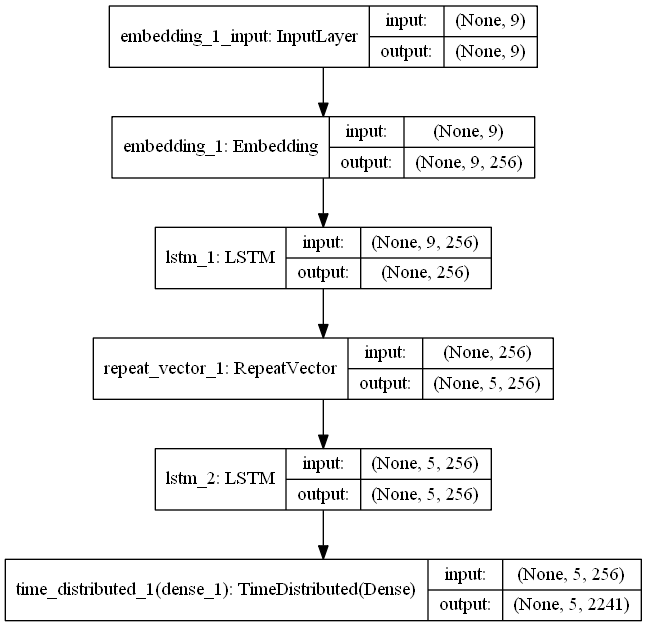

In [30]:
plot_model(model, to_file='model.png', show_shapes=True)

#### fit model

>We train the model for 40 epochs and a batch size of 64 examples.

>We use checkpointing to ensure that each time the model skill on the test set improves, the model is saved to file.

In [31]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=40, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/40
 - 35s - loss: 4.1370 - val_loss: 3.3374

Epoch 00001: val_loss improved from inf to 3.33741, saving model to model.h5
Epoch 2/40
 - 30s - loss: 3.2214 - val_loss: 3.1921

Epoch 00002: val_loss improved from 3.33741 to 3.19208, saving model to model.h5
Epoch 3/40
 - 30s - loss: 3.0843 - val_loss: 3.1283

Epoch 00003: val_loss improved from 3.19208 to 3.12830, saving model to model.h5
Epoch 4/40
 - 30s - loss: 2.9473 - val_loss: 2.9814

Epoch 00004: val_loss improved from 3.12830 to 2.98143, saving model to model.h5
Epoch 5/40
 - 31s - loss: 2.7800 - val_loss: 2.8794

Epoch 00005: val_loss improved from 2.98143 to 2.87937, saving model to model.h5
Epoch 6/40
 - 31s - loss: 2.6384 - val_loss: 2.7688

Epoch 00006: val_loss improved from 2.87937 to 2.76885, saving model to model.h5
Epoch 7/40
 - 32s - loss: 2.4956 - val_loss: 2.6780

Epoch 00007: val_loss improved from 2.76885 to 2.67

## Evaluate Neural Translation Model

>We will evaluate the model on the train and the test dataset.

>The model should perform very well on the train dataset and ideally have been generalized to perform well on the test dataset.

>Ideally, we would use a separate validation dataset to help with model selection during training instead of the test set.

#### map an integer to a word

>The function below, named word_for_id(), will perform this reverse mapping.

In [32]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

>We can perform this mapping for each integer in the translation and return the result as a string of words

#### generate target given source sequence

>function predict_sequence() below performs this operation for a single encoded source phrase

In [33]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

#### evaluate the skill of the model

>Evaluation involves two steps: first generating a translated output sequence, and then repeating this process for many input examples and summarizing the skill of the model across multiple cases.

>Starting with inference, the model can predict the entire output sequence in a one-shot manner.

In [34]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src, test = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

>we can repeat this for each source phrase in a dataset and compare the predicted result to the expected target phrase in English.

>We can print some of these comparisons to screen to get an idea of how the model performs in practice.

>We will also calculate the BLEU scores to get a quantitative idea of how well the model has performed.

>evaluate_model() function above implements this, calling the above predict_sequence() function for each phrase in a provided dataset.

#### best model saved during training must be loaded

In [35]:
# load model
model = load_model('model.h5')

#### load datasets

In [36]:
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

#### prepare english tokenizer

In [37]:
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

#### prepare german tokenizer

In [38]:
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])

#### prepare data

In [39]:
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

#### test on some training sequences

In [40]:
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)

train
src=[konnt ihr helfen], target=[can you help], predicted=[can you help]
src=[er ist mein feind], target=[he is my enemy], predicted=[he is my enemy]
src=[unterschreiben sie hier], target=[sign here], predicted=[sign here]
src=[druckt mir die daumen], target=[wish me luck], predicted=[wish me luck]
src=[ich habe mich ubergeben], target=[i threw up], predicted=[i threw up]
src=[tom ist in panik geraten], target=[tom panicked], predicted=[tom panicked]
src=[bleib gelassen], target=[keep cool], predicted=[keep cool]
src=[ich bin], target=[im], predicted=[im bleeding]
src=[du schuldest mir was], target=[you owe me], predicted=[you owe me]
src=[er ist schauspieler], target=[he is an actor], predicted=[he is an actor]
BLEU-1: 0.905413
BLEU-2: 0.868479
BLEU-3: 0.769475
BLEU-4: 0.435577


#### test on some test sequences

In [41]:
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

test
src=[ich brauche freunde], target=[i need friends], predicted=[i need rock]
src=[los gehts], target=[here we go], predicted=[go go it]
src=[ich habe sie gebaut], target=[i built it], predicted=[i built it]
src=[ich bin geschieden], target=[i am divorced], predicted=[im greedy]
src=[beginnen sie noch einmal], target=[start again], predicted=[start again]
src=[das ist ein scherz], target=[thats a joke], predicted=[this is a joke]
src=[uberlass es ihm], target=[let him do it], predicted=[let it to him]
src=[wir versuchen es], target=[we try], predicted=[well know it]
src=[setz dich], target=[sit down], predicted=[sit a]
src=[ich habe nachgeschaut], target=[ive checked], predicted=[i got kids]
BLEU-1: 0.569107
BLEU-2: 0.452451
BLEU-3: 0.369568
BLEU-4: 0.174259
